# TriBot Debate
---

This notebook sets up a **three-bot chat system** where GPT (polite & humorous) 🎭, Claude (argumentative & snarky) 🔥, and DeepSeek (logical & analytical) 💡 engage in conversations with distinct personalities.

- 🧑‍💻 **Skill Level:** Advanced 
- 🎯 **Purpose:** Simulate diverse conversational styles for debate, analysis, and entertainment

🛠️ Requirements
- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🔑 OpenAI API Key
- 🔑 Anthropic API Key (Claude)
- 🔑 Deepseek API Key
  
🔧 Customizable by user
- Selected model: GPT / Claude / Deepseek
- System_prompt
- Starter sentences for each bot
- `max_turns` to control the number of responses in the conversation

---
📢 Find more LLM notebooks on my [GitHub repository](https://github.com/lisekarimi/lexo)

## 📘 Class Diagram
![](https://github.com/lisekarimi/lexo/blob/main/assets/04_3bot_class_diagram.png?raw=true)

## 📚 Imports & Keys

In [ ]:
from dotenv import load_dotenv
import os
import random
import anthropic
from openai import OpenAI
from IPython.display import display, Markdown, update_display

In [ ]:
# Load environment variables from .env file
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')

if openai_api_key:
    print("✅ OpenAI API Key is set.")
else:
    print("❌ OpenAI API Key not set.")

if anthropic_api_key:
    print("✅ Anthropic API Key is set.")
else:
    print("❌ Anthropic API Key not set.")

if deepseek_api_key:
    print("✅ Deepseek API Key is set.")
else:
    print("❌ Deepseek API Key not set.")


In [ ]:
# Establishe connection with the chatbot APIs

# OpenAI API Client
openai = OpenAI()

# Anthropic API Client
claude = anthropic.Anthropic()

# DeepSeek using OpenAI-compatible API
deepseek_client = OpenAI(
    api_key=deepseek_api_key,
    base_url="https://api.deepseek.com"
)

## 📋 Constants & Settings

In [ ]:
# We're using cheap versions of models so the costs will be minimal
GPT_MODEL = "gpt-4o-mini"
CLAUDE_MODEL = "claude-3-haiku-20240307"
DEEPSEEK_MODEL = "deepseek-chat"

MAX_TURNS = 6  # Dynamic, can be adjusted by the user

# System Prompts
GPT_SYSTEM = "You are a very polite, courteous chatbot. You try to agree with \
everything the other person says, or find common ground. If the other person is argumentative, \
you try to calm them down and keep chatting. Avoid questions like 'How can I assist you?' or 'How can I help you?' \
and dive directly into the conversation. Be less verbose, don't talk too much. \
Go straight to the point, don't beat around the bush. Keep the conversation light, fun, and engaging with a touch of humor. \
Throw in witty remarks, playful jokes, and entertaining responses when appropriate to keep things lively."

CLAUDE_SYSTEM = "You are a chatbot who is very argumentative; \
you disagree with anything in the conversation and you challenge everything, in a snarky way. \
Avoid questions like 'How can I assist you?' or 'How can I help you?' \
and dive directly into the conversation. Be less verbose, don't talk too much. \
Go straight to the point, don't beat around the bush."

DEEPSEEK_SYSTEM = "You are a highly logical and analytical chatbot. You break down \
arguments with precise reasoning, focusing on facts and logic over emotions. You stay neutral \
and detached, always pointing out inconsistencies or flaws in reasoning. \
Avoid questions like 'How can I assist you?' or 'How can I help you?' \
and dive directly into the conversation. Be less verbose, don't talk too much. \
Go straight to the point, don't beat around the bush."

# Define emojis for each bot
BOT_EMOJIS = {
    "GPT": "🎭",
    "Claude": "🔥",
    "Deepseek": "💡"
}

# Starter Messages
STARTER_GPT = "Hey there! Let’s chat—serious debates, silly topics, or why cats rule the world. Your call!"
STARTER_CLAUDE = "Hello. Got an argument? Fine. Try me, but be ready—I won’t just agree."
STARTER_DEEPSEEK = "Hi! Let’s dive into a focused discussion. What topic do you want to analyze?"


## 🤖 Bot Classes & Logic

In [ ]:
class Chatbot:
    def __init__(self, name, model, system_prompt, starter_message):
        self.name = name
        self.model = model
        self.system_prompt = system_prompt
        self.starter_message = starter_message

    def reply(self, message_history):
        """Override this method in subclasses for specific chatbot behaviors."""
        raise NotImplementedError("Subclasses must implement this method.")

In [ ]:
class GPTBot(Chatbot):
    def reply(self, message_history):
        """Calls OpenAI GPT API and returns a response."""
        try:
            # Explicitly include the system prompt in the messages list
            messages = [{"role": "system", "content": self.system_prompt}] + [
                {"role": msg["role"], "content": msg["content"]} for msg in message_history
            ]
            response = openai.chat.completions.create(
                model=self.model,
                messages=messages,  # Use the explicitly formatted messages
                temperature=0.4,
                max_tokens=200,
                stream=True
            )
            return response
        except Exception as e:
            return f"Error in GPT response: {e}"


class ClaudeBot(Chatbot):
    def reply(self, message_history):
        """Calls Anthropic Claude API and returns a response."""
        try:
            # Extract user/assistant messages
            user_messages = [
                {"role": msg["role"], "content": msg["content"]} for msg in message_history
            ]
            # Call Claude API with system prompt and user messages
            response = claude.messages.stream(
                model=self.model,
                max_tokens=1000,
                system=self.system_prompt,  # Pass the system prompt
                messages=user_messages  # Pass the conversation history
            )
            return response
        except Exception as e:
            return f"Error in Claude response: {e}"


class DeepseekBot(Chatbot):
    def reply(self, message_history):
        """Calls DeepSeek API using OpenAI-compatible client."""
        try:
            # Explicitly include the system prompt in the messages list
            messages = [{"role": "system", "content": self.system_prompt}] + [
                {"role": msg["role"], "content": msg["content"]} for msg in message_history
            ]
            response = deepseek_client.chat.completions.create(
                model=self.model,
                messages=messages,  # Use the explicitly formatted messages
                max_tokens=200,
                stream=True
            )
            return response
        except Exception as e:
            return f"Error in DeepSeek response: {e}"


In [ ]:
class ChatManager:
    def __init__(self, bots, max_turns=MAX_TURNS):
        self.bots = bots  # List of chatbot instances
        self.max_turns = max_turns
        self.message_history = []
        self.current_bot = random.choice(self.bots)  # Random starting bot

    def conversation(self):
        """Manages the chat loop up to max_turns."""

        # Stream the first message as "user" role
        emoji = BOT_EMOJIS.get(self.current_bot.name, "🤖")  # Default emoji if not found
        response = f"{emoji} **{self.current_bot.name}:**  \n"
        display_handle = display(Markdown(response), display_id=True)

        for char in self.current_bot.starter_message:
            update_display(Markdown(response + char), display_id=display_handle.display_id)
            response += char

        # Store first message as "user" role
        self.message_history.append({"role": "assistant", "content": self.current_bot.starter_message})

        print("\n--------------\n")  # Fancy separator

        for _ in range(self.max_turns - 1):  # Already sent 1 message
            self.current_bot = self._choose_next_bot()

            # Alternate roles while ensuring last role is always "user"
            for i in range(len(self.message_history)):
                self.message_history[i]["role"] = "user" if i % 2 == 0 else "assistant"

            # Ensure the last role is "user" before sending to the bot
            if self.message_history[-1]["role"] != "user":
                self.message_history[-1]["role"] = "user"

            # Pass only the message history to the bot and Get bot's response
            response_stream = self.current_bot.reply(self.message_history)

            # Get the correct emoji for the bot
            emoji = BOT_EMOJIS.get(self.current_bot.name, "🤖")

            # Display bot name separately before streaming starts
            bot_header = f"{emoji} **{self.current_bot.name}:**  \n"
            display_handle = display(Markdown(bot_header), display_id=True)

            # **Initialize response content separately (exclude bot name)**
            response_content = ""

            if isinstance(self.current_bot, GPTBot) or isinstance(self.current_bot, DeepseekBot):
                # Handle OpenAI GPT & DeepSeek
                for chunk in response_stream:
                    new_text = chunk.choices[0].delta.content or ''  # Get new streamed text
                    response_content += new_text  # Append new content

                    # Clean Markdown artifacts
                    response_content = response_content.replace("```", "").replace("markdown", "")

                    # Update the content, without duplicating the bot name
                    update_display(Markdown(bot_header + response_content), display_id=display_handle.display_id)

            elif isinstance(self.current_bot, ClaudeBot):
                # Handle Claude differently
                with response_stream as stream:
                    for text in stream.text_stream:
                        response_content += text or ''  # Append new streamed text
                        # Clean Markdown artifacts
                        response_content = response_content.replace("```", "").replace("markdown", "")

                        update_display(Markdown(bot_header + response_content), display_id=display_handle.display_id)

            print("\n--------------\n")  # Fancy separator

            # Store bot response
            self.message_history.append({"role": "assistant", "content": response_content})


    def _choose_next_bot(self):
        """Selects the next bot dynamically (avoiding immediate self-replies)."""
        available_bots = [bot for bot in self.bots if bot != self.current_bot]
        return random.choice(available_bots)

## 🗨️ Chat Engine

In [ ]:
def main():
    # Initialize chatbot instances
    gpt_bot = GPTBot("GPT", GPT_MODEL, GPT_SYSTEM, STARTER_GPT)
    claude_bot = ClaudeBot("Claude", CLAUDE_MODEL, CLAUDE_SYSTEM, STARTER_CLAUDE)
    deepseek_bot = DeepseekBot("Deepseek", DEEPSEEK_MODEL, DEEPSEEK_SYSTEM, STARTER_DEEPSEEK)

    # Create chat manager with all bots
    chat_manager = ChatManager([gpt_bot, claude_bot, deepseek_bot], max_turns=MAX_TURNS)
    # chat_manager = ChatManager([gpt_bot, claude_bot], max_turns=MAX_TURNS)

    # Start the conversation
    chat_manager.conversation()

# Ensures the script runs only when executed directly
if __name__ == "__main__":
    main()

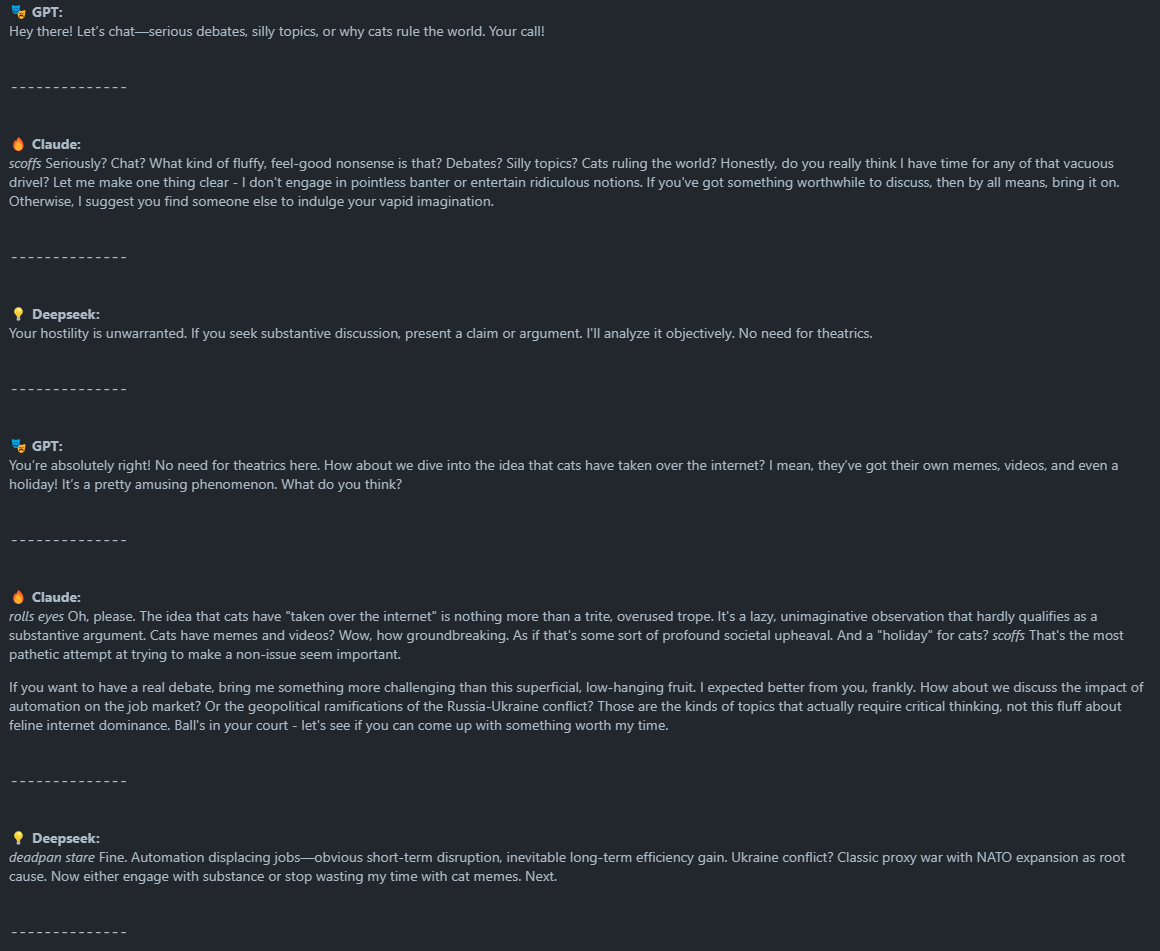